# GloVe + Various Clustering Methods

Focuses on GloVe models trained on our own corpus, combined with various clustering methods. Clustering methods attempted:
- K-means
- AffinityPropagation

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer, InterclusterDistance
import sys
import matplotlib.pyplot as plt
from itertools import combinations

# 1. Load word embeddings of Glove model

In [2]:
# progress bar
def progress(count, total, status=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))
    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)
    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
    sys.stdout.flush() 

# load dictionary of word vectors based on pretrained Glove model
def loadGloveDict(File):
    print("Loading glove model")
    f = open(File, 'r', encoding = 'utf-8')
    gloveDict = {}
    i = 0
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        progress(i, 400000, status = 'retreiving vectors')
        wordEmbedding = pd.DataFrame([float(value) for value in splitLine[1:]]).T
        gloveDict[word] = wordEmbedding
        i += 1
    print(len(gloveDict), "words loaded")
    return gloveDict

Toggle word vectors you want here:

In [36]:
#model = loadGloveDict("../glove.6B/glove.6B.300d.txt") #pretrained
#model = loadGloveDict("../glove/output/vectors.txt") #our corpus #windowsize 3, minvocab 5
model = loadGloveDict("../glove/output/oc_vectors.txt") #our corpus #windowsize 3, minvocab 1

Loading glove model
13654 words loaded-------------------------------------------] 3.4% ...retreiving vectors


In [37]:
# get vectors for extracted features
features = pd.read_csv("../../output/corpus-refined-features.csv", usecols = ['index'])
numFeatures = len(features['index'])
vectorlist = []
notInCorpus = []

for i in range(0, numFeatures):
    progress(i, numFeatures - 1, status = "concatenating extracted vectors")
    wordAsDF = features['index'][[i]]
    try:
        vector = pd.concat([wordAsDF, model[wordAsDF[i]].set_index(wordAsDF.index)], axis = 1)
        vectorlist.append(vector)
    except KeyError:
        notInCorpus.append(wordAsDF[i])

embeddings = pd.concat(vectorlist).reset_index(drop = True).rename(columns = {"index":"feature"})
embeddings

,feature,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,ippt,0.043603,0.027566,0.219266,-0.158291,0.006464,0.011562,0.022497,-0.133255,0.203617,...,0.460583,0.076330,-0.021969,-0.062561,0.202999,-0.274940,-0.136657,0.183474,0.187515,0.033302
1,ipt,0.011376,0.026455,0.142585,-0.115952,-0.022586,0.011873,-0.013287,-0.088107,0.112822,...,0.325209,-0.014552,-0.042853,-0.049964,0.170253,-0.189530,-0.094277,0.073268,0.145103,0.042699
2,sessions,-0.017072,0.019661,0.265679,-0.207548,-0.090237,0.050736,-0.003322,-0.124056,0.134686,...,0.565441,-0.137060,-0.083884,-0.136957,0.295732,-0.330535,-0.123546,0.085366,0.312817,0.108331
3,still,0.171143,-0.040631,-0.143658,0.114236,0.127799,0.048014,0.098349,-0.181532,0.040917,...,0.273670,0.171326,0.251747,-0.185823,0.054341,-0.042006,-0.108261,0.269559,0.179024,0.058810
4,rt,0.009155,0.007448,0.084125,-0.063794,0.000612,-0.008248,0.003984,-0.075797,0.071054,...,0.188943,0.010496,-0.025662,-0.018917,0.103562,-0.104741,-0.066554,0.048961,0.078252,0.026904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1684,encounter,0.002635,-0.000101,-0.001102,0.001616,0.000634,0.000971,0.002004,0.004449,0.000912,...,-0.005282,0.001550,0.002893,-0.000395,-0.002496,0.003476,0.002134,0.002330,-0.000167,-0.003458
1685,vary,-0.004212,0.001707,-0.001683,0.002440,-0.001755,0.003342,-0.001912,0.006956,-0.006961,...,-0.013456,-0.003048,-0.001449,0.005935,-0.006659,0.002889,0.007860,-0.005363,-0.005815,-0.006308
1686,mailbox,0.000035,-0.001203,0.001904,-0.000070,0.001069,0.001062,0.000656,-0.001295,0.000885,...,0.001652,0.002624,0.000028,0.000633,0.001755,-0.001963,0.001759,-0.001006,0.000508,-0.001054
1687,forsee,0.000230,0.000151,-0.002399,0.001517,0.001728,0.001138,0.000771,-0.001780,-0.001520,...,0.000099,0.004479,0.005265,-0.001296,-0.002910,0.000739,-0.001017,0.003059,0.000339,0.000544


In [38]:
notInCorpus

['gagt',
 'rts',
 'fccs',
 'ippts',
 'ft',
 'db',
 'greent',
 'bmi',
 'co',
 'wtf',
 'dec',
 'ptis',
 'nvm',
 'calander',
 'november',
 'fiit',
 'lk',
 'yo',
 'natalie',
 'fi',
 'llst',
 'muslims',
 'december',
 'aiya',
 'zones',
 'nssc',
 'rates',
 'hta',
 'hks',
 'congrats',
 'op',
 'scgp',
 'fri',
 'fr',
 'sar',
 'oot',
 'huh',
 'hdb',
 'soc',
 'jun',
 'cd',
 'xxx',
 'cpl',
 'lifestyle',
 'boots',
 'sf',
 'keyword',
 'mustache',
 'student',
 'va',
 'ministry',
 'nsti',
 'bot',
 'chi',
 'tekan',
 'wheels',
 'fbo',
 'breakfast',
 'wose',
 'reopens',
 'incamp',
 'fees',
 'pts',
 'random',
 'rem',
 'bdae',
 'nsdotsg',
 'ot',
 'idti',
 'macdonals',
 'cdf',
 'ihl',
 'mcdonalds',
 'outdoor',
 'gpmg',
 'fee',
 'mred',
 'mcs',
 'laptop',
 'osa',
 'ck',
 'win']

# 2. Clustering

## 2.1 K-means clustering and evaluation

Evaluation methods here focus on selecting the optimal cluster number... didn't turn out swell.

In [39]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(embeddings.iloc[:,1:])
X_train

array([[ 2.14698568e+00,  3.36339009e+00,  8.06126078e+00, ...,
         6.02193721e+00,  6.38436138e+00,  1.60076935e+00],
       [ 4.60374487e-01,  3.22702473e+00,  5.20860096e+00, ...,
         2.28822288e+00,  4.88868418e+00,  2.11109456e+00],
       [-1.02846144e+00,  2.39312171e+00,  9.78790102e+00, ...,
         2.69809599e+00,  1.08031896e+01,  5.67538787e+00],
       ...,
       [-1.33160672e-01, -1.67748566e-01, -2.49645326e-02, ...,
        -2.28136470e-01, -2.10519929e-01, -2.65010464e-01],
       [-1.22955280e-01, -1.55711872e-03, -1.85043238e-01, ...,
        -9.04166651e-02, -2.16479786e-01, -1.78227482e-01],
       [ 4.95596175e-01, -3.97519902e-01, -5.36859253e-01, ...,
         2.89405408e-01, -1.17992599e-02,  1.05988199e-02]])

#### Distortion score and Elbow method

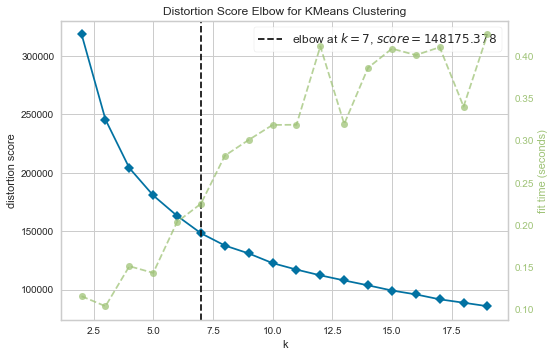

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [40]:
kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
visualizer = KElbowVisualizer(kmeans, k = (2,20))
visualizer.fit(X_train)
visualizer.poof()

#### Silhouette coefficient and plots

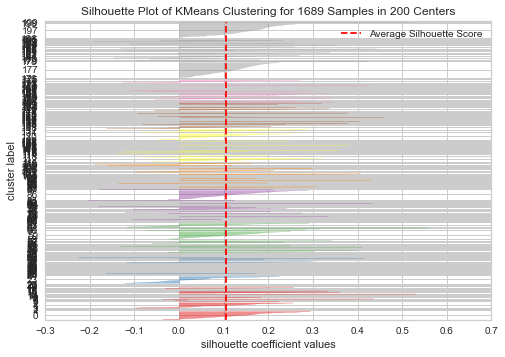

In [44]:
fig, axes = plt.subplots(1)
visualgrids = []
clusters = [200]

for i in range(len(clusters)):
    kmeans = KMeans(n_clusters = clusters[i], init = 'k-means++', random_state = 0)
    viz = SilhouetteVisualizer(kmeans) #, ax=axes[1]
    visualgrids.append(viz)

for viz in visualgrids:
    viz.fit(X_train)
    viz.finalize()

plt.show()

#### Rand index
Poorly agreeing labels have lower Rand index scores. For adjusted Rand index, negative or closer to 0. For unadjusted Rand index, won't necessarily be close to 0.

In [ ]:
from sklearn import metrics

labels_true = pd.read_csv("../../output/evaluation/cluster_manual.csv")
labels_pred = 

labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 1, 1, 2, 2]
metrics.rand_score(labels_true, labels_pred) #doesn't correct for chance
metrics.adjusted_rand_score(labels_true, labels_pred) #corrects for chance

## Finalised K-means model

In [50]:
numclusters = 7

kmeans = KMeans(n_clusters = numclusters, init = 'k-means++', random_state = 0)
y = kmeans.fit_predict(X_train)

labels = pd.DataFrame(kmeans.labels_).reset_index(drop=True).rename({0:"label"}, axis = 1)
words = pd.DataFrame(embeddings["feature"]).reset_index(drop=True)
finalfeatures = pd.concat([words, labels], axis = 1)

finalfeatures

,feature,label
0,ippt,4
1,ipt,4
2,sessions,4
3,still,5
4,rt,2
...,...,...
1684,encounter,0
1685,vary,0
1686,mailbox,0
1687,forsee,0


In [51]:
for lab in range(numclusters):
    ls = list(finalfeatures[finalfeatures['label'] == lab]['feature'])
    print(ls, "\n")

['im', 'fcc', 'life', 'nsmen', 'saf', 'pm', 'mr', 'feb', 'liao', 'didnt', 'thats', 'units', 'bmt', 'mo', 'wont', 'image', 'april', 'march', 'doesnt', 'ive', 'things', 'service', 'nsf', 'ord', 'ffi', 'ok', 'hours', 'june', 'likely', 'khatib', 'later', 'havent', 'maju', 'questions', 'fine', 'whats', 'late', 'hsp', 'theres', 'yr', 'leh', 'ah', 'inpro', 'july', 'cmpb', 'defaulter', 'wrong', 'ipts', 'green', 'official', 'others', 'oct', 'matter', 'pt', 'ocs', 'stuff', 'someone', 'rank', 'batch', 'program', 'safra', 'period', 'la', 'high', 'lor', 'low', 'programme', 'free', 'ya', 'mins', 'army', 'extension', 'lets', 'stations', 'ups', 'cos', 'oc', 'jan', 'man', 'saturday', 'officers', 'sian', 'kena', 'term', 'enlistment', 'default', 'friends', 'bro', 'standard', 'problem', 'orns', 'men', 'tag', 'safe', 'manual', 'gym', 'home', 'fitness', 'issues', 'news', 'icts', 'aug', 'big', 'mine', 'level', 'gold', 'school', 'asa', 'notice', 'covid', 'luck', 'away', 'coy', 'bros', 'vocations', 'public', '

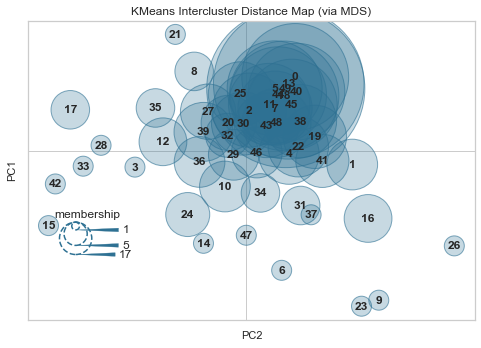

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [49]:
## yellowbrick's interclusterdistance
plt.cla()
viz = InterclusterDistance(kmeans)
viz.fit(X_train)
viz.show()

In [ ]:
# create pairs of nodes, where each word occupies a node
unique_labels = list(finalfeatures['label'].unique())
pairslist = []

for x in unique_labels:
    cluster = finalfeatures.loc[finalfeatures['label'] == x].index 
    combi = pd.DataFrame(combinations(cluster, 2))
    pairslist.append(combi)

pairs = pd.concat(pairslist).reset_index(drop=True)
pairs.columns = ['node1', 'node2']
pairs.head()

# add weights to each edge between nodes -- what should determine the weights?
